# 房价预测

#训练的数据集来自kesci网
#pandas 数据处理基础:https://thinkwee.top/2017/02/04/pandas-skill/
#数据预处理的函数解释:https://www.jianshu.com/p/e2d705e9f38d
#参考文章：https://github.com/CodingHHW/project/blob/master/%E6%88%BF%E4%BB%B7%E9%A2%84%E6%B5%8B/house_pre.ipynb

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import skew

In [3]:
from sklearn.model_selection import train_test_split#划分训练集和测试集用的
from sklearn.linear_model import LinearRegression #线性回归学习器,用线性拟合用的
from sklearn.preprocessing import StandardScaler#标准化,why要标准化呢？使得不同的量纲具有可比性


#划分训练集和测试集的目的:我用一套卷子训练你能力,不能再用这套卷子考你
#why要标准化呢？使得不同的量纲具有可比性
#一般我们如何衡量区别呢,量化出一个长度来,比如说实例和实例的区别,我们要计算出
#他们的距离,比如我要比较两个人区别,比如说身高(140cm;180cm),体重,眼睛大小(1.5cm,1cm)
#眼睛并不能决定距离大小,因为身高权重值太大了;除非这两者之间单位为1，才具有可比性;

###3一次输入的特征值为12个，输出为1个预测房价，假设 隐藏层有两层

In [4]:
n_hidden_1=256
n_hidden_2=128
n_input=10
n_output=1

batch_size=128

In [11]:
##测试集
x_test=pd.read_csv("E:\machine_learning\house\house_test.csv")
# 训练集
x_train=pd.read_csv("E:\machine_learning\house\house_train.csv")
y_train=pd.read_csv("E:\machine_learning\house\house_train2.csv")
# y_train = np.log(y_train["price"]+1)
x_train.shape

(1900, 12)

In [12]:
x_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1900.0,950.500000,548.627074,1.0,475.75,950.5,1425.25,1900.0
distirct,1900.0,91.501579,48.831297,1.0,54.00,96.0,133.25,164.0
green_rate,1897.0,52.329995,6.983080,28.0,47.00,52.0,57.00,75.0
area,1900.0,81.551053,6.269196,65.0,77.00,81.0,85.00,140.0
oriented,1900.0,0.750526,0.432822,0.0,1.00,1.0,1.00,1.0
traffic,1900.0,64.798421,13.954334,27.0,55.00,67.0,75.00,97.0
shockproof,1900.0,57.943158,15.117303,12.0,49.75,61.0,68.00,90.0
school,1900.0,2.357368,0.752159,1.0,2.00,2.0,3.00,4.0
crime_rate,1896.0,5.786340,1.036407,2.5,5.10,5.9,6.50,8.7
pm25,1900.0,63.007895,10.489366,28.0,57.00,64.0,70.00,89.0


In [165]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 12 columns):
id            1900 non-null int64
distirct      1900 non-null int64
built_date    1900 non-null object
green_rate    1897 non-null float64
area          1900 non-null int64
floor         1900 non-null object
oriented      1900 non-null int64
traffic       1900 non-null int64
shockproof    1900 non-null int64
school        1900 non-null int64
crime_rate    1896 non-null float64
pm25          1900 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 178.2+ KB


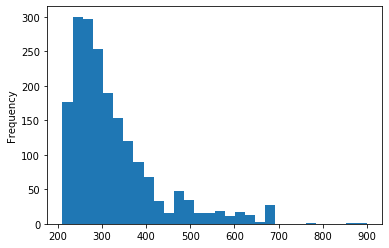

In [166]:
y_train["price"].plot.hist(bins=30)

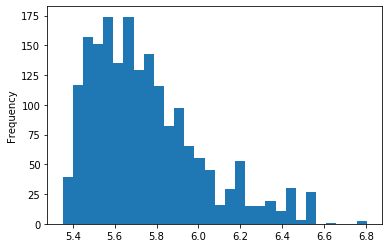

In [167]:
np.log1p(y_train['price']).plot.hist(bins=30)

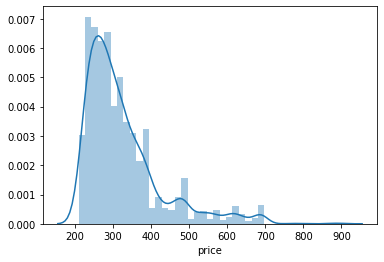

In [168]:
sns.distplot(y_train['price'])

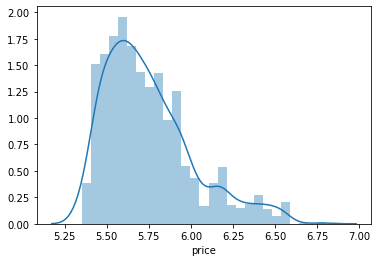

In [169]:
sns.distplot(np.log1p(y_train['price']))

# 数据预处理

In [ ]:
# 将训练和测试数据放在一块儿进行处理，去除训练数据的第一列
all_data = pd.concat((x_train.loc[:,'distirct':'pm25'],x_test.loc[:,'distirct':'pm25']))
# print(all_data)
all_data['floor']=all_data['floor'].map({'Low':1,'Medium':2,'High':3,}).astype(int)
x_train['floor']=x_train['floor'].map({'Low':1,'Medium':2,'High':3,}).astype(int)
x_test['floor']=x_test['floor'].map({'Low':1,'Medium':2,'High':3,}).astype(int)
#去掉一列
x_train = x_train.drop(['built_date'], axis = 1)
x_test = x_test.drop(['built_date'], axis = 1)

x_train=x_train.loc[:,'distirct':'pm25']
x_test=x_test.loc[:,'distirct':'pm25']
x_train.describe()

In [171]:
# 将特征中 偏斜度>0.75的特征 取log1p
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index

skewed_feats = x_train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
#print(skewed_feats)
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
# all_data.describe()
# sns.distplot(all_data["area"])

# 这是一个其他测试用例

In [185]:
x = np.arange(10,dtype = np.float16)
print('x-orig:', x)
sess = tf.Session()
x = tf.constant(x, dtype = tf.float32)
[x_mean, x_varia] = tf.nn.moments(x, axes=0)
offset = 0
scale = 0.1
vari_epsl = 0.0001
## calculate the batch normalization
x_bn = tf.nn.batch_normalization(x, x_mean, x_varia, offset,scale,vari_epsl)
print('mean & vari: ', sess.run( [x_mean, x_varia]))
x_bn_res = sess.run(x_bn)
print('x_bn:', x_bn_res)



x-orig: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
mean & vari:  [4.5, 8.25]
x_bn: [-0.15666895 -0.12185362 -0.0870383  -0.05222298 -0.01740766  0.01740767
  0.05222298  0.08703831  0.12185363  0.15666895]



# 归一化

In [184]:
sx_train=[]
for i in range(10):
    x_x = tf.constant(x_train[i], dtype = tf.float32)
    [x_mean, x_varia] = tf.nn.moments(x_x, axes=0)
    offset = 0
    scale = 0.1
    vari_epsl = 0.0001
    ## calculate the batch normalization
    x_bn = tf.nn.batch_normalization(x_x, x_mean, x_varia, offset,scale,vari_epsl) 
    print(sess.run(x_bn))
    sx_train=tf.add()

SyntaxError: invalid syntax (<ipython-input-184-d76d3aa97392>, line 7)

# 正文

In [172]:
x=tf.placeholder("float32",[None,n_input])
y=tf.placeholder("float32",[None,n_output])

weights={
    "w1":tf.Variable(tf.random_normal([n_input,n_hidden_1],stddev=0.1),dtype="float32"),
    "w2":tf.Variable(tf.random_normal([n_hidden_1,n_hidden_2],stddev=0.1),dtype="float32"),
    "out":tf.Variable(tf.random_normal([n_hidden_2,n_output],stddev=0.1),dtype="float32")
}

biases={
    "b1":tf.Variable(tf.random_normal([n_hidden_1]), dtype="float32"),
    "b2":tf.Variable(tf.random_normal([n_hidden_2]), dtype="float32"),
    "out":tf.Variable(tf.random_normal([n_output]), dtype="float32")
}

# 建立回归模型

In [181]:
def multilayer_perceptron(_x,_weights,_biases):
    layer1=tf.nn.relu(tf.add(tf.matmul(tf.cast(_x,tf.float32),_weights["w1"]),_biases["b1"]))
    layer2=tf.nn.relu(tf.add(tf.matmul(tf.cast(layer1,tf.float32),_weights["w2"]),_biases["b2"]))
    return (tf.nn.relu(tf.add(tf.matmul(tf.cast(layer2,tf.float32),_weights["out"]),_biases["out"])))

pre=multilayer_perceptron(x,weights,biases)



loss=tf.reduce_mean(tf.reduce_sum(tf.square(y-pre),reduction_indices=[1]))  
train_step=tf.train.GradientDescentOptimizer(0.001).minimize(loss)                      
# correct=tf.equal(pre,y_train)

init=tf.initialize_all_variables()

sess=tf.Session()
sess.run(init)

batch_size=100

for i in range(50):
    #training
    sess.run(train_step,feed_dict={x:x_train[:1],y:y_train[:1]})
    for j in range (100):
        print("预测值：")
        prediction_value=sess.run(pre,feed_dict={x:x_train})
        print("loss=",sess.run(loss,feed_dict={x:x_train,y:y_train}))

预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss= nan
预测值：
loss=

KeyboardInterrupt: 